# Modeling neural activity as state and rate-of-change encoding
This notebook details the model fitting procedure used for de Jong et al. 2014 published [here](https://www.nature.com/articles/s41593-023-01547-6). The Notebook is accompanied by the following example data:
- neurons.json: contains the activity of 4 simultaneously recorded neurons (Z-score normalized).
- task_and_events.json: contains the task events translated in time between 0 and -500ms during 1 recording session.
- trial_structure: contains a DataFrame where every trial in this recording session is one row.

Note that in this notebook we'll fit just one recording session, whereas in reality we combined multiple recording sessions into one dataset (more on this below).

Author: Han de Jong (UC Berkeley)

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as spo
import seaborn as sns
from sklearn.metrics import mean_squared_error


In [2]:
# Load the data

# These are the task event kernels
behavior = pd.read_json('task_and_events.json')
behavior.index = np.array([i.value/10**9 for i in behavior.index])

# These are the z-score normalized neural activity patterns
neurons = pd.read_json('neurons.json')
neurons = neurons.dropna(axis=0)
neurons.index = behavior.index

# This is the trial structure
trials = pd.read_json('trial_structure.json')

In [3]:
# Here we initialize the parameters for the model

# We have 4 task-related inputs that are translated in time by 500ms because we
# use 100ms bins, that means we have 5 parameters per input as well as one
# bias (or intercept) parameter.
state_params = np.random.randn(behavior.shape[1])*0.01 + 0.1

# For every unit we'll fit 2 parameters. These are referred to as 'A' (for
# amplitude) and 'B' (for bias) in the paper.
neuron_weights = 0.5+np.random.randn(2*neurons.shape[1])*0.1

# We combine the parameters into a single vector that we'll pass to the
# optimization function
params = np.append(state_params, neuron_weights)


Neurons, including VTA dopamine neurons, cannot fire at a negative rate. For instance, if a neuron's baseline firing rate is 4Hz, it can increase to 25Hz, but it cannot go into negative values, such as -21Hz. Therefore, when the firing rate is below the baseline (referred to as "inhibition"), the range of possible firing rates is more limited. To model how the dynamic range of firing frequencies changes above and below the baseline, we calculated the standard deviation of the firing rates both lower and higher than the baseline, as illustrated in Figure 4b of the paper.

In [4]:
# The 'rescaling' factor below the baseline (by definition this is a Z-score of 0)
relu_leak = 0.4162

In [5]:
# This is how we calculate the 'state' and its derivative
def state_and_diff(input_vector, params):
    """
    The 'state' is the dot product of the input vector (i.e. task_and_events)
    and the parameters (task-event kernels). The derivative is the rate of 
    change of the state.

    We (arbitrarily) calculate the derivative over the 100ms (1-bin) interval.
    We've also done other intervals, which results in (good looking) 'smooth'
    plots, but feels even more arbitrary. In general we decided to systematically
    bin both our ephys data and FIP data to 100ms bins as is commonly done in
    these types of studies.

    Note that "params" passed to this function is a vector that contains only
    the 'state' params, not he 'A' and 'B' params (which are applied in the
    next layer of the model).
    """
    
    # Calculate the value (dot product) and activation function
    state = np.dot(input_vector, params)
    dstatedt = np.append(0, np.diff(state))

    # Apply the leaky ReLU to the diff
    dstatedt = np.where(dstatedt>0, dstatedt, dstatedt*relu_leak)
    
    return np.concatenate([state.reshape(-1, 1), dstatedt.reshape(-1, 1)], axis=1)
    


The function below is the target for minimization during the optimization of our model. Note that in this case we use the behavior from 1 recording session and we fit this to the activity of 4 units. This is only possible because the 4 units in this particular recording session happened to span the variation of the general population. This makes for a nice lightweight illustration of the model. In reality, the mice in the paper were recorded multiple times and we combined data obtained during multiple recordings. Importantly when we fit individual sessions, the same 21 coefficients were used to produce the state vector.  This is because we assume that the latent variables ‘state’ and ‘Δstate/Δt’ are mouse-specific (not session specific). By forcing the model to explain all neural activity patterns (36±7.8 neurons per mouse), it increases the chance that the model will learn meaningful internal representations based on the behavioral task structure for individual mice. 

In [6]:
# Define the loss function
loss_function = mean_squared_error

# Define the fitting function
def fit_neurons(params, behavior, neurons, return_prediction = False):
    """ 
    This function is responsible for fitting the task-event kernels to the
    state vector and then to fit the state and its derivative to the neurons.
    """
    
    # Grab the params for the first layer
    n_state_params = behavior.shape[1]
    
    # Get the state and Δstate/Δt vectors
    X = state_and_diff(behavior, params[:n_state_params])
    
    # Reshape the other params so a dot product gives the neuronal activity
    # The top row contains 'A' and the bottom row contains 'B'.
    w = params[n_state_params:].reshape(2, -1, order='F')
    
    # Implementing a constraint on the model parameters. Specifically, we want
    # the model to use B and 1-B to fit the neurons. The 0-1 constraint for B is
    # set using the 'bounds' parameters of spo.minimize later in this notebook.
    w = np.vstack((w, (1-w[1, :]).reshape(1, -1)))

    # Making the prediction
    prediction = np.dot(X, w[1:, :]) # Using B and 1-B to fit neurons
    prediction = prediction * w[0, :] # Multiplying by the 'A' parameter
    
    # Calculate the loss
    loss = loss_function(neurons, prediction)  
    
    # Return predictions or just loss?
    if return_prediction:
        prediction = pd.DataFrame(columns=neurons.columns, 
                                  index = neurons.index,
                                  data=prediction)    
        # Calculate the loss for every neuron
        loss = {}
        for neuron in neurons.columns:
            loss[neuron] = loss_function(neurons[neuron].values,
                                         prediction[neuron].values)
        
        return prediction, loss
    else:
        return loss


The two functions in the subsequent cell are designed exclusively for visualization. They display the activity of a specific neuron during a randomly selected trial. As the optimization process minimizes the fit function, these functions will dynamically update the plots for the 'state' and 'Δstate/Δt' vectors. This visualization aids in understanding the actions of the optimizer. It's important to clarify that these plots represent the values for the 'state' and 'Δstate/Δt' during that specific trial, reflecting the behavior of the mouse at that moment. These are not averaged values across multiple trials.

An additional point to note: In this instance, we fitted the model using all available data. However, in the paper, we employed a 10-fold cross-validation approach. This meant fitting the model 10 times, each time omitting 10% of the trials from the training set. We then assessed the model on this excluded 10%, using it to reconstruct predictions. Because of the model's relatively few parameters (21 plus 2 for each unit) and the extensive dataset (behavior and neural data binned in 100ms intervals), this cross-validation process did not significantly alter the final fit.

In [7]:
# Do we actually want to use these functions
show_progress_during_fitting = True

# The example input_vector is used to visualize the fitting
def build_example_vector(behavior, neurons, trial = 18):
    
    # Load the data
    example_vector = behavior.copy()

    # Add the spikes
    example_vector['spikes'] = neurons.iloc[:, 0].values # make it 4 later

    # Find the start time of the trial
    while not trials.loc[trial, 'trial_type'] == 'CS+':
        print('NOTE: this is not a reward trial, picking a different one')
        trial = trial + 1
    start_time = trials.loc[trial, 'start']
    
    # Cut out the part around the example trial
    indexer = (example_vector.index>=start_time-2) & (example_vector.index<start_time+9.9)   
    example_vector = example_vector[indexer]
    example_vector.index = example_vector.index-start_time
    
    # For the example vector BUT NOWHERE ELSE do we rescale the spikes to 1
    example_vector.loc[:, 'spikes'] = example_vector.spikes / example_vector.spikes.max()
    
    return example_vector

# Put the example vector in the namespace
example_vector = build_example_vector(behavior, neurons)

# Function that updates the user during fitting
def optimize_callback(params):
    """
    Works on a GLOBAL variable called example_vector.

    NOTE: "spikes" is the last column of the example vector
    """
    # Add state and diff to the example vector
    X = state_and_diff(example_vector.iloc[:, :-1], params[:behavior.shape[1]])
    X = pd.DataFrame(columns=['state', 'diff'], index=example_vector.index, data=X)
    
    # Do we have to make a new figure?
    make_new_figure = False
    if (not plt.get_fignums()):
        make_new_figure = True
    else:
        ax = plt.gca()
        if not ax.get_title() == 'optimization results':
            make_new_figure = True

    # Is this the first time or are we looking at a different figure? -> Make a new figure
    if make_new_figure:      
        fig, ax = plt.subplots(1)
        ax.set_title('optimization results')
        ax.vlines(0, -1, 1, color='k', linestyle='--')
        ax.set_ylabel('Parameter Value')
        ax.set_xlabel('Time (s)')    
    else:
        fig = plt.gcf()
    
    # Make a plot that updates
    X.state.plot(color='blue')
    X['diff'].plot(color='orange')
    example_vector.spikes.plot(color='black')

    # Update the legend
    ax.legend(['Example unit activity (Z-score normalized)', 'State', 'Δstate/Δt'])
    
    # Make sure to only plot the last 5 itterations
    while len(ax.lines)>15:
        ax.lines[0].remove()
    
    # Force draw
    fig.canvas.draw()
    fig.canvas.flush_events()

Loss function: mean_squared_error
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Note how the 'State' vector looks a bit block-like, which is a consequence of the limited number of units in this dataset.


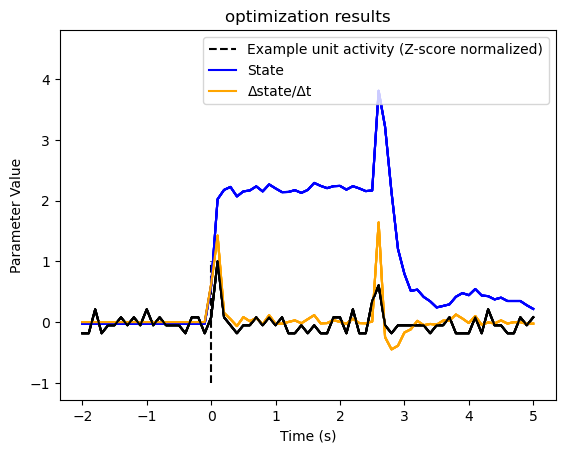

In [8]:
# Here we do the model fitting

# Update the user
print(f'Loss function: {loss_function.__name__}')

# Grab start parameters
start_prediction, start_individual_loss = fit_neurons(params, behavior, neurons, True)
start_loss = fit_neurons(params, behavior, neurons)

# Implementing model constraints (parameters bounds). Specifically we want B to be
# between 0 and 1. There are no bounds for the parameters that fit the task-event
# kernels to the state nor for the amplitude 'A' parameter.
n_state_params = behavior.shape[1]
bounds = [(None, None)] * n_state_params
neuron_bounds = [(None, None), (0, 1)]*int((len(params)-n_state_params)/2)
bounds.extend(neuron_bounds)

# This does the actual fitting
if show_progress_during_fitting:
    # Make sure we get a floating window
    %matplotlib qt
    results = spo.minimize(fit_neurons, params, args=(behavior, neurons),
                            callback=optimize_callback, bounds=bounds)
    %matplotlib inline
    fig = plt.figure(); plt.close(fig) #Move the figure inline
else:
    results = spo.minimize(fit_neurons, params, args=(behavior, neurons), bounds=bounds)
print(results['message'])

# Print a note
print("Note how the 'State' vector looks a bit block-like, which is a consequence of the limited number of units in this dataset.")

In [9]:
# Let's collect the results
# Put the fitted parameters in a DataFrame
fitted_params = results['x'][n_state_params:].reshape(2, -1, order='F')
fitted_params = pd.DataFrame(columns=neurons.columns, 
                                index=['A', 'B'],
                                data = fitted_params).transpose()

# State params
state_params = pd.DataFrame(index = behavior.columns, data = results['x'][:n_state_params])

# Finally run fit_neurons again to calculate the fit for every neuron
final_prediction, final_individual_loss = fit_neurons(results['x'],
                                    behavior, neurons, True)


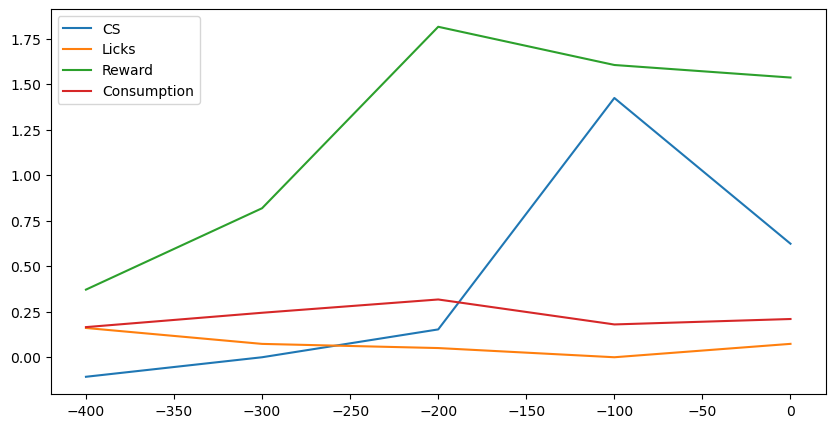

In [10]:
# Let's have a look at the task-event kernels
%matplotlib inline
fig, ax = plt.subplots(1, figsize=(10, 5))
X = [0, -100, -200, -300, -400]
for i in range(1, 17, 5):
    ax.plot([0, -100, -200, -300, -400], state_params.iloc[i:i+5, :], 
            label = state_params.index[i].split('_')[0])
plt.legend();

In this particular case the model did not really use licking (both reward seeking as well as reward consumption) to model the 'state'. Note that 'CS' and 'Reward' are task events whereas licking behavior is a choice of the animal. We would be very careful to draw conclusions about the nature of the 'state' that is encoded by DA neurons from this. In fact we propose that it is highly likely (and we believe that some of our reviewers agreed with this) that NAcMed DA release tracks motivated behavior. For instance, note the difference in NAcMed DA release between 'Go' and 'No-Go' trials (Figure 2l) and the similarity in NAcMed DA release and licking behavior in figure 2m and Extended Data Figure 8.

In [11]:
# These are the functions we'll use to make peri-event plots
%matplotlib inline

def peri_event_data(stamps, signal, start = -2, end = 5):
    """
    This functions makes the peri-event data of the 'signal' setting the timestamps
    in 'stamps' to T=0.

    Start and end define the window size of the data relative to T=0.
    """

    output = pd.DataFrame(columns = np.linspace(1, len(stamps), len(stamps)))
    for i, stamp in enumerate(stamps):
        indexer = (signal.index>=stamp+start) & (signal.index<stamp+end)
        output[i+1] = signal[indexer].values

    output.index = np.linspace(start, end-0.1, output.shape[0])

    return output

def peri_event(stamps, signal, start = -2, end = 5, mean = True, ax = None,
               color='k', label = None):
    """
    This function uses peri_event_data to obtain a peri-event dataset and
    them plots it to tha axis 'ax' or a newly created axis if 'ax' is None.
    """

    # Make a figure if necessary
    if ax is None:
        fig, ax = plt.subplots(1, tight_layout=True)

    # Grab the data
    data = peri_event_data(stamps, signal, start, end)

    # Plot the data
    if mean:
        data.mean(axis=1).plot(ax=ax, color=color, linewidth=2)
    else:
        data.plot(ax=ax, color=color, alpha=0.1, label=label, linewidth=2)

    return ax

Text(0.5, 1.0, 'Δstate/Δt')

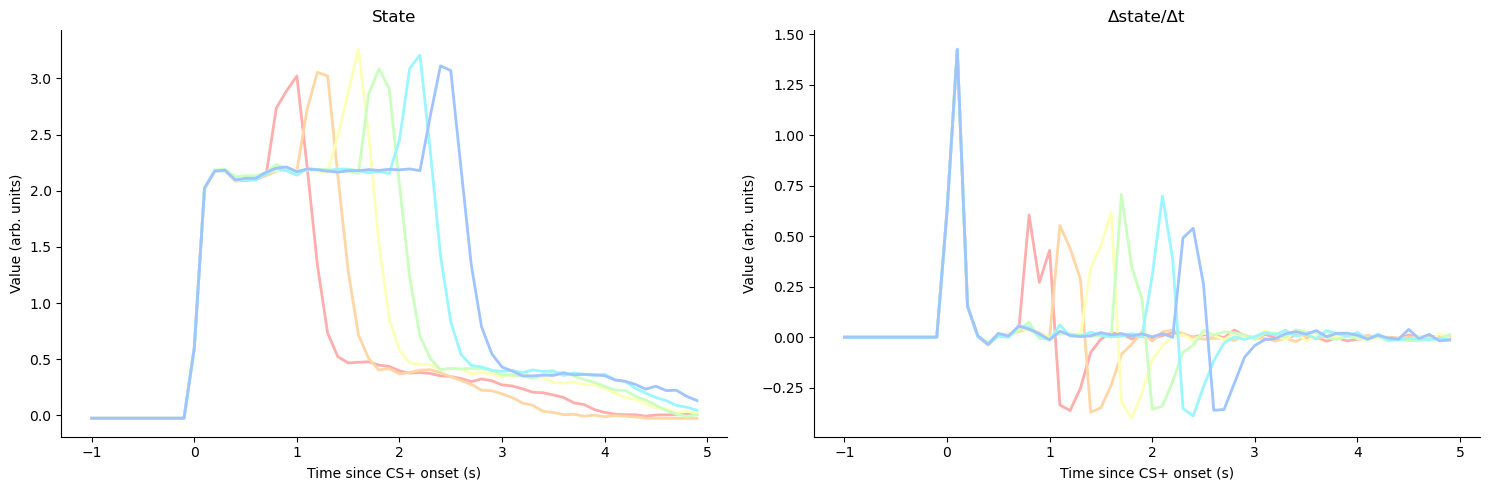

In [12]:
# Let's plot some results
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)

# Grab the state and Δstate/Δt
X = state_and_diff(behavior, results['x'][:n_state_params])
X = pd.DataFrame(columns=['state', 'Δstate/Δt'], index=behavior.index, data=X)

# Colors
colors = ["#ffadad", "#ffd6a5", "#fdffb6", "#caffbf", "#9bf6ff", "#a0c4ff", "#bdb2ff"]

# Plot the state and Δstate/Δt
for i in range(1, 8):
    indexer = trials.interval_type==i
    stamps = trials.loc[indexer, 'start']
    peri_event(stamps, X.state,  start = -1, end = 5, mean = True, ax = axs[0], label=i, color=colors[i-1])
    peri_event(stamps, X['Δstate/Δt'],  start = -1, end = 5, mean = True, ax = axs[1], label=i, color=colors[i-1])

# Some formatting
for ax in axs:
    ax.set_xlabel('Time since CS+ onset (s)')
    ax.set_ylabel('Value (arb. units)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
axs[0].set_title('State')
axs[1].set_title('Δstate/Δt')

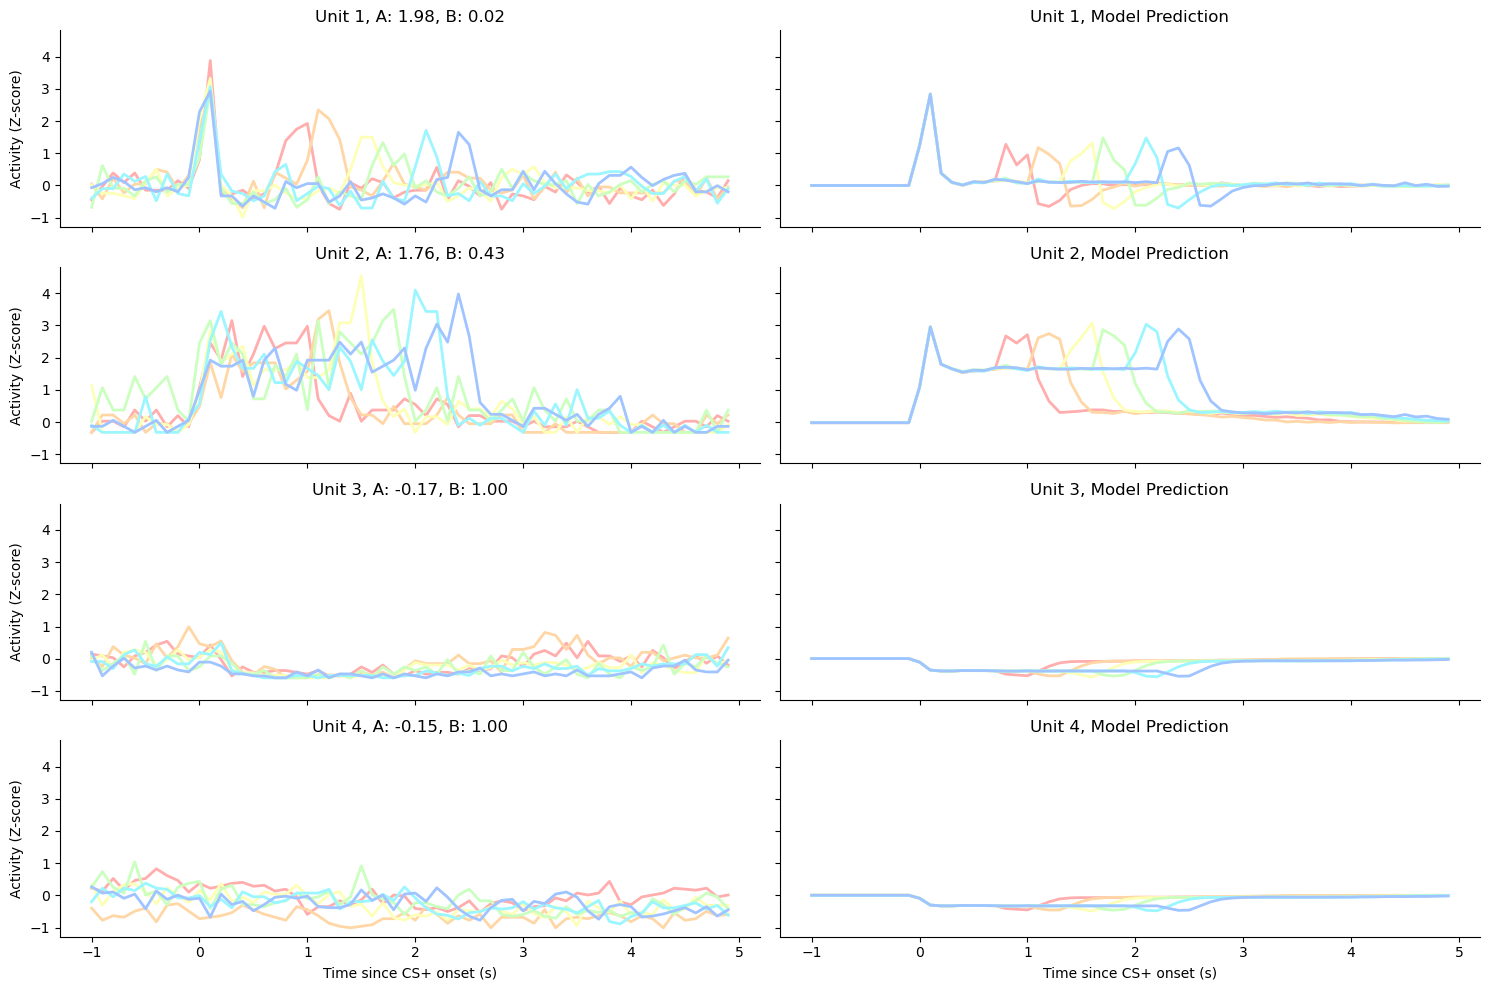

In [13]:
# Plot the neurons
fig, axs = plt.subplots(4, 2, figsize=(15, 10), tight_layout=True, sharex=True, sharey=True)

for i, neuron in enumerate(neurons.columns):
    for j in range(1, 8):
        indexer = trials.interval_type==j
        stamps = trials.loc[indexer, 'start']
        peri_event(stamps, neurons[neuron],  start = -1, end = 5, mean = True, ax = axs[i, 0], label=i, color=colors[j-1])
        peri_event(stamps, final_prediction[neuron],  start = -1, end = 5, mean = True, ax = axs[i, 1], label=i, color=colors[j-1])

# Some formatting
for ax in axs.flatten():
    ax.set_xlabel('Time since CS+ onset (s)')
    ax.set_ylabel('Activity (Z-score)')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
for i in range(1, 5):
    axs[i-1, 0].set_title(f'Unit {i}, A: {fitted_params.loc[i, "A"]:.2f}, B: {fitted_params.loc[i, "B"]:.2f}')
    axs[i-1, 1].set_title(f'Unit {i}, Model Prediction')


### Conclusion
This notebook demonstrates the model fitting process used for Figure 4 in our paper. Note that this demonstration of the model only works with so few neurons because this particular set happened to contain 1 neuron of each type.

- Unit 1 (Type 2 neuron): This neuron shows activity spikes at the cue onset and reward delivery. The model identifies it as a predominantly 'Δstate/Δt' neuron (indicated by a low 'B' value) and does so with high confidence (high 'A' value).
- Unit 2 (Type 3 neuron): This neuron exhibits continuous activity between the start of the conditioned stimulus (CS+) and reward delivery, with occasional spikes at both the CS+ onset and reward delivery. The model categorizes it as a 'mixed' neuron (with 'B' value around 0.5), encoding both 'state' and 'Δstate/Δt'.
- For both Unit 3 and Unit 4, There is no apparent correlation between this neuron's activity and the behavior being modeled. (Unit 3 might show a minor inhibition during reward seeking, but note that the 'A' parameters is very small.)





